In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
import joblib

# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

C:\Users\aa271\AppData\Local\Temp\ipykernel_28308\3475265594.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
datajh=pd.read_csv("groupedjh.csv")

In [31]:
datap=datajh[(datajh["Season"]=="Summer") ].groupby("Hour_Min").mean().reset_index()

C:\Users\aa271\AppData\Local\Temp\ipykernel_28308\3276289342.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datap=datajh[(datajh["Season"]=="Summer") ].groupby("Hour_Min").mean().reset_index()


In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) *RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

X=datap[["Hour","地面层温度"]]
y=datap.异戊二烯浓度

In [37]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\aa271\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9)

In [38]:
# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X, return_std=True)

C:\Users\aa271\AppData\Local\Temp\ipykernel_28308\1809958532.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(datap.groupby("Hour").mean().reset_index().Hour, datap.groupby("Hour").mean().reset_index().异戊二烯浓度, 'r-', markersize=10, linewidth=2.5, label='Observations')
C:\Users\aa271\AppData\Local\Temp\ipykernel_28308\1809958532.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(datap.groupby("Hour").mean().reset_index().Hour, datap.groupby("Hour").mean().reset_index().异戊二烯浓度, 'r-', markersize=10, linewidth=2.5, label='Observations')
C:\Users\aa271\AppData\Local\Temp\ipykernel_28308\18

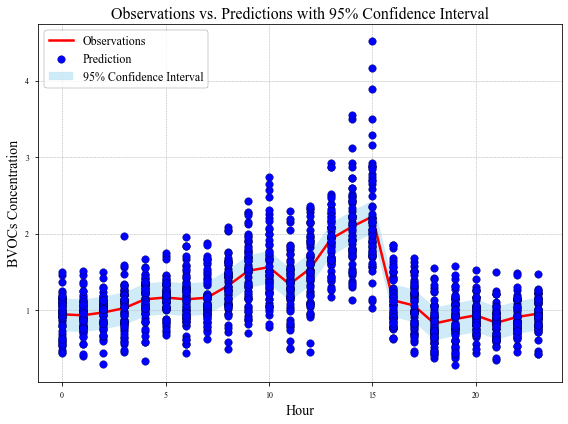

In [69]:
from sklearn.metrics import mean_squared_error
residuals = y - y_pred  # 计算残差
Xt=X.copy()
Xt["y"]=y_pred

mse = mean_squared_error(y, y_pred)  # 计算均方误差
std_error = np.sqrt(mse)  # 计算标准误差

# 计算95%置信区间
conf_interval = 1.96 * std_error  # 对于95%的置信区间
upper_bound = Xt.groupby("Hour").mean().reset_index().y + conf_interval
lower_bound = Xt.groupby("Hour").mean().reset_index().y - conf_interval

# 绘制图形和置信区间
plt.figure(figsize=(8, 6))
plt.plot(datap.groupby("Hour").mean().reset_index().Hour, datap.groupby("Hour").mean().reset_index().异戊二烯浓度, 'r-', markersize=10, linewidth=2.5, label='Observations')
plt.scatter(X.iloc[:,0], y_pred, color='blue', edgecolors='k', s=60, label='Prediction', zorder=5)
plt.fill_between(datap.groupby("Hour").mean().reset_index().Hour, lower_bound, upper_bound, color='skyblue', alpha=0.4, label="95% Confidence Interval")

plt.xlabel('Hour', fontsize=14)
plt.ylabel('BVOCs Concentration', fontsize=14)
plt.title('Observations vs. Predictions with 95% Confidence Interval', fontsize=16)
plt.legend(loc='upper left', fontsize=12, edgecolor='k')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"GP FIT.svg", bbox_inches='tight')
plt.show()

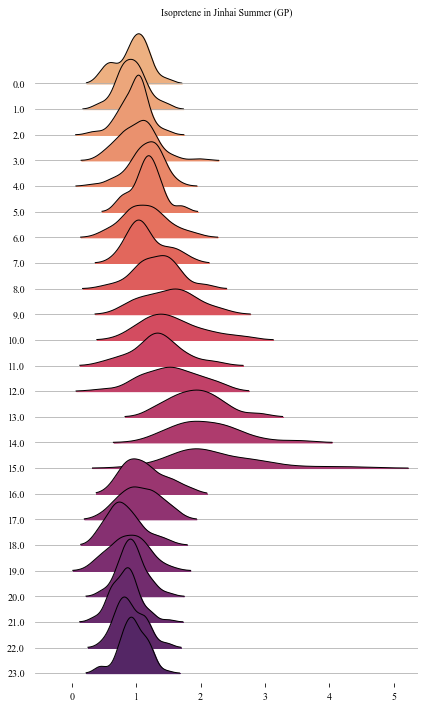

In [70]:
import joypy
# 使用joypy绘制结果
fig, axes = joypy.joyplot(
    Xt,
    by="Hour",
    column="y",
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(6,10),
    title="Isopretene in Jinhai Summer (GP)",
    colormap=sns.color_palette("flare", as_cmap=True)
)
plt.savefig(f"GP DIS.svg", bbox_inches='tight')